# 1. AirBnB price trend

In [148]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [149]:
pd.set_option("display.max.columns", None)
pd.set_option('min_rows', 10)

### 1.1 Load the data

In [150]:
df_boston_calendar = pd.read_csv('boston\calendar.csv', sep=',')
df_seattle_calendar = pd.read_csv('seattle\calendar.csv', sep=',')

In [151]:
df_boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


### 1.2 Process the data

In [152]:
# combine calendars of Boston and Seattle
df_calendar = pd.concat([df_boston_calendar, df_seattle_calendar], keys=['boston', 'seattle'], names=['city','i'], sort=False)
df_calendar.rename(columns={'listing_id': 'id'}, inplace=True)
df_calendar.head()

id        date available price
city   i                                      
boston 0  12147973  2017-09-05         f   NaN
       1  12147973  2017-09-04         f   NaN
       2  12147973  2017-09-03         f   NaN
       3  12147973  2017-09-02         f   NaN
       4  12147973  2017-09-01         f   NaN

In [153]:
df_calendar.reset_index(inplace=True)

# drop available='f'
df_calendar.dropna(inplace=True)
df_calendar.drop(axis=1, columns=['i'], inplace=True)
df_calendar.head()

,city,id,date,available,price
365,boston,3075044,2017-08-22,t,$65.00
366,boston,3075044,2017-08-21,t,$65.00
367,boston,3075044,2017-08-20,t,$65.00
368,boston,3075044,2017-08-19,t,$75.00
369,boston,3075044,2017-08-18,t,$75.00


In [154]:
df_calendar.shape

(1577579, 5)

In [155]:
# convert string price to numeric
df_calendar.replace('[$,]', '', regex=True, inplace=True)
df_calendar.price = df_calendar.price.astype(float)

# convert string date to actual date
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

# convert id(listing_id) to string
df_calendar.id = df_calendar.id.astype('O')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002006AD711C8>]],
      dtype=object)

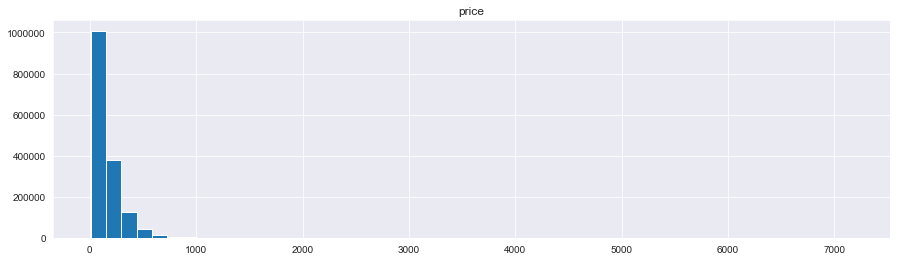

In [156]:
# check price distribution
df_calendar.hist(figsize=(15, 4), bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002006AFD2648>]],
      dtype=object)

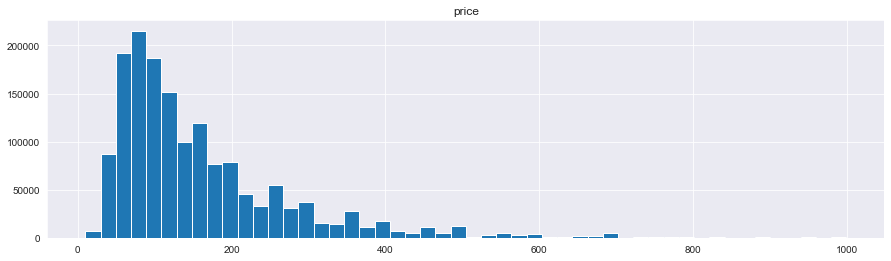

In [157]:
df_calendar[(df_calendar.price < 1000)].hist(figsize=(15, 4), bins=50)

In [158]:
# drop records with price >= $700 (most of the records have price within $700/day)
df_calendar = df_calendar[df_calendar.price < 700]
df_calendar.shape

(1564289, 5)

In [159]:
# add some date variables for each plotting
df_calendar['YEAR'] = df_calendar.date.apply(lambda x: x.strftime('%Y'))
df_calendar['MONTH'] = df_calendar.date.apply(lambda x: x.strftime('%B'))
df_calendar['month'] = df_calendar.date.apply(lambda x: x.strftime('%m'))
df_calendar['WEEKDAY'] = df_calendar.date.apply(lambda x: x.strftime('%A'))
df_calendar['weekday'] = df_calendar.date.apply(lambda x: x.strftime('%w'))
df_calendar['YYYYMM'] = df_calendar['YEAR'] + df_calendar['month']
df_calendar.head()

,city,id,date,available,price,YEAR,MONTH,month,WEEKDAY,weekday,YYYYMM
365,boston,3075044,2017-08-22,t,65.0,2017,August,08,Tuesday,2,201708
366,boston,3075044,2017-08-21,t,65.0,2017,August,08,Monday,1,201708
367,boston,3075044,2017-08-20,t,65.0,2017,August,08,Sunday,0,201708
368,boston,3075044,2017-08-19,t,75.0,2017,August,08,Saturday,6,201708
369,boston,3075044,2017-08-18,t,75.0,2017,August,08,Friday,5,201708


In [160]:
df_calendar['YYYY-MM'] = df_calendar['YEAR'] + '-' + df_calendar['month']
df_calendar['WeekDay'] = df_calendar['weekday'] + '-' + df_calendar['WEEKDAY']
df_calendar.head()

,city,id,date,available,price,YEAR,MONTH,month,WEEKDAY,weekday,YYYYMM,YYYY-MM,WeekDay
365,boston,3075044,2017-08-22,t,65.0,2017,August,08,Tuesday,2,201708,2017-08,2-Tuesday
366,boston,3075044,2017-08-21,t,65.0,2017,August,08,Monday,1,201708,2017-08,1-Monday
367,boston,3075044,2017-08-20,t,65.0,2017,August,08,Sunday,0,201708,2017-08,0-Sunday
368,boston,3075044,2017-08-19,t,75.0,2017,August,08,Saturday,6,201708,2017-08,6-Saturday
369,boston,3075044,2017-08-18,t,75.0,2017,August,08,Friday,5,201708,2017-08,5-Friday


### 1.3a Calculate daily average rental price by city

In [161]:
df_calendar_mean_price_city_date = df_calendar.groupby(['city','date'])['price'].mean()
df_calendar_mean_price_city_date = df_calendar_mean_price_city_date.reset_index()
df_calendar_mean_price_city_date.head()

,city,date,price
0,boston,2016-09-06,235.348673
1,boston,2016-09-07,246.603896
2,boston,2016-09-08,243.106061
3,boston,2016-09-09,253.857438
4,boston,2016-09-10,256.309322


### 1.3b Plot daily average rental price by city

Text(0, 0.5, 'daily average rental price')

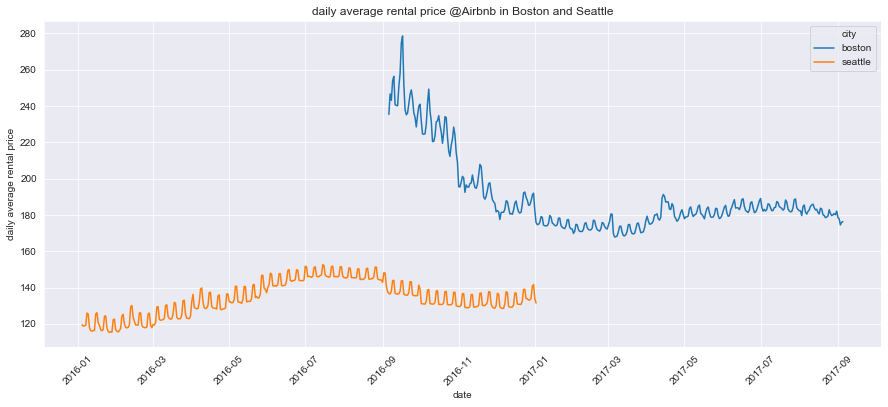

In [162]:
# plot
# https://cmdlinetips.com/2019/04/how-to-specify-colors-to-scatter-plots-in-python/

sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
sns.lineplot(x=df_calendar_mean_price_city_date.date, 
             y=df_calendar_mean_price_city_date.price, 
             data=df_calendar_mean_price_city_date, hue='city')
plt.title('daily average rental price @Airbnb in Boston and Seattle')
plt.ylabel('daily average rental price')

### 1.4a Calculate monthly average rental price by city

In [163]:
df_calendar_mean_price_city_month = df_calendar.groupby(['city','month'])['price'].mean()
df_calendar_mean_price_city_month = df_calendar_mean_price_city_month.reset_index()
df_calendar_mean_price_city_month_pivot = \
                            df_calendar_mean_price_city_month.pivot(index='month', columns='city', values='price')
df_calendar_mean_price_city_month_pivot['diff'] = df_calendar_mean_price_city_month_pivot.boston - \
                                                  df_calendar_mean_price_city_month_pivot.seattle
df_calendar_mean_price_city_month_pivot

city,boston,seattle,diff
month,,,
01,175.495119,120.379709,55.115410
02,172.960755,120.769052,52.191704
03,172.315801,124.938345,47.377456
04,181.030356,131.498440,49.531916
05,180.740529,135.930507,44.810022
06,183.987053,144.110780,39.876273
07,184.421001,147.912624,36.508377
08,181.883284,146.458517,35.424767
09,226.238506,139.138093,87.100413


### 1.4b-1 Linechart plot monthly average rental price by city

Text(0, 0.5, 'monthly average price $')

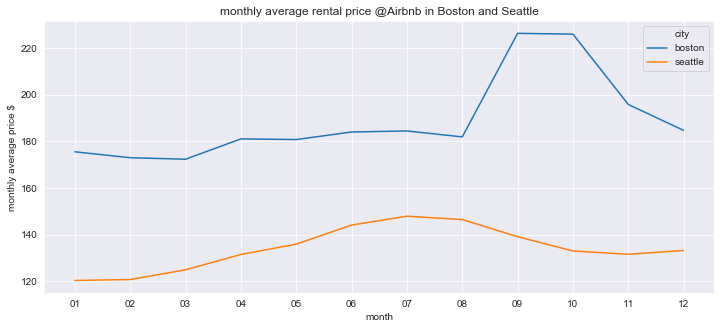

In [164]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,5))
ax = sns.lineplot(x=df_calendar_mean_price_city_month.month, 
                  y=df_calendar_mean_price_city_month.price, 
                  data=df_calendar_mean_price_city_month, hue='city')
plt.title('monthly average rental price @Airbnb in Boston and Seattle')
plt.ylabel('monthly average price $')
# ax.set(title='monthly average rental price @AirBnB in Boston and Seattle', ylabel='monthly average price $')

### 1.4b-2 Barchart plot monthly average rental price by city 

Text(0, 0.5, 'monthly average price $')

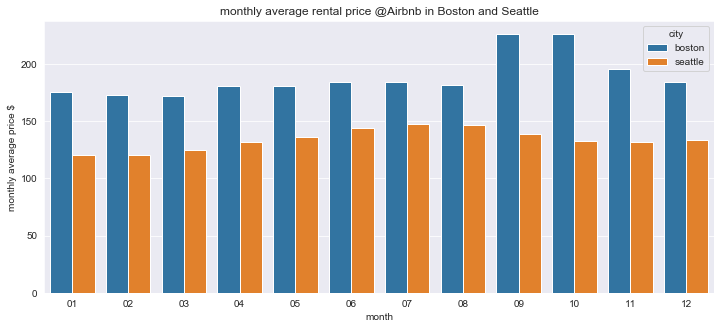

In [165]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,5))
ax = sns.barplot(x=df_calendar_mean_price_city_month.month, 
                 y=df_calendar_mean_price_city_month.price, 
                 data=df_calendar_mean_price_city_month, hue='city')
plt.title('monthly average rental price @Airbnb in Boston and Seattle')
plt.ylabel('monthly average price $')
# plt.ylim(120, 240)

### 1.5a Calculate weekday average rental price by city

In [166]:
df_calendar_mean_price_city_weekday = df_calendar.groupby(['city', 'WeekDay'])['price'].mean()
df_calendar_mean_price_city_weekday = df_calendar_mean_price_city_weekday.reset_index()
df_calendar_mean_price_city_weekday
df_calendar_mean_price_city_weekday_pivot = \
                        df_calendar_mean_price_city_weekday.pivot(index='WeekDay', columns='city', values='price')
df_calendar_mean_price_city_weekday_pivot['diff'] = df_calendar_mean_price_city_weekday_pivot.boston - \
                                                    df_calendar_mean_price_city_weekday_pivot.seattle
df_calendar_mean_price_city_weekday_pivot

city,boston,seattle,diff
WeekDay,,,
0-Sunday,186.678288,132.677756,54.000532
1-Monday,184.874580,131.805800,53.068780
2-Tuesday,184.371507,131.571103,52.800404
3-Wednesday,184.962679,131.681904,53.280775
4-Thursday,186.699843,132.764815,53.935028
5-Friday,190.239257,139.335302,50.903955
6-Saturday,190.523086,139.472621,51.050465


### 1.5b-1 Linechart plot weekday average rental price by city

Text(0, 0.5, 'weekday average price $')

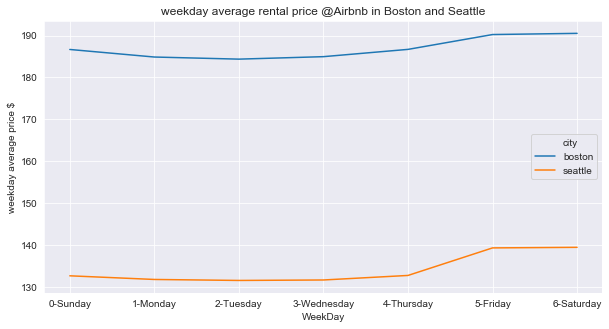

In [167]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=df_calendar_mean_price_city_weekday.WeekDay, 
                  y=df_calendar_mean_price_city_weekday.price, 
                  data=df_calendar_mean_price_city_weekday, hue='city')
# plt.ylim(120, 210)
plt.title('weekday average rental price @Airbnb in Boston and Seattle')
plt.ylabel('weekday average price $')

### 1.5b-2 Barchart plot weekday average rental price by city

Text(0, 0.5, 'weekday average price $')

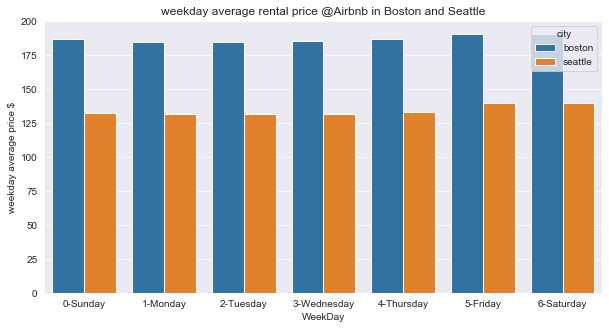

In [168]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_calendar_mean_price_city_weekday.WeekDay, 
                 y=df_calendar_mean_price_city_weekday.price, 
                 data=df_calendar_mean_price_city_weekday, hue='city')
# plt.ylim(130, 200)
plt.title('weekday average rental price @Airbnb in Boston and Seattle')
plt.ylabel('weekday average price $')

### 1.6 Summary
* Within the same period (Sep 6, 2016 to Jan 2, 2017), daily average rental price (DAR price) is higher in Boston (\\$191) than in Seattle (\\$136).
* DAR price in both Seattle and Boston shows a strong seasonal pattern. 
 * In both cities, DAR price is relatively low at the beginning of the year and gradually increases as the season enters summer. 
 * The months of peak DAR price varies though for each city. In Seattle, DAR price is relatively high from May through September, with June (\\$146), July (\\$150), and August (\\$148) the obvious top three,  more than \\$10 more than the annual average. In Boston, DAR price is relatively high from September through November, with September (\\$229) and October (\\$228) the obvious top two, close to \\$30 more than the annual average.
* DAR price in both Seattle and Boston also shows a strong weekday pattern as shown in the above plot by many small peaks. Each peak cycle corresponds to one week. 
 * In both cities, DAR price is relatively high on Friday and Saturday, close to \\$6~$7 more than the annual average.

# 2. Boston Listing Data Cleaning

### 2.1 Load the data

In [169]:
# read boston listing data, ignore 'access','interaction','house_rules' columns, set 'id' as index
df_boston = pd.read_csv('boston\listings.csv', sep=',', index_col='id', 
                 usecols = lambda column : column not in ['access','interaction','house_rules'],
                 parse_dates=['last_scraped', 'host_since'], na_filter=True)

In [170]:
df_boston.head(1)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...",https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


In [171]:
df_boston.shape

(3585, 91)

### 2.2 Drop unnecessary columns
feat_info.csv was manually created and contains info about necessary property/actions to each column, such as id, numeric, categorical, location, drop, convert to numeric and convert to date etc.
It is worth mentioning why certain columns were dropped.
1. host_total_listings_count/calculated_host_listings_count: high correlation with host_listings_count
2. host_verifications: use host_identity_verified
3. zipcode: use neighbourhood_cleansed 
4. weekly_price/monthly_price: somewhat related to dependent variable or target daily 'price'. From an AirBnB home landlord's perspective, he/she is mostly like to set the daily 'price' first, before setting weekly_price/monthly_price charge.
5. number_of_reviews: use reviews_per_month

In [172]:
feat_info = pd.read_csv('feat_info.csv', sep=',')

# drop unnecessary columns
column_dropped_1 = feat_info[feat_info.action == 'drop']['name'].to_list()
df_boston.drop(columns = column_dropped_1, axis=1, inplace = True)
df_boston.shape

(3585, 43)

### 2.3 Convert data
'extra_people' is somewhat related to dependent variable or target 'price'. From a home landlord's perspective, he/she is mostly like to set the price first, before setting 'extra_people' charge. This means 'extra_people' can be ignored. However, 'extra_people' does affect the 'price' to some extend. To keep this effect, 0/1 dummy was used. The same applies to security_deposit' and 'cleaning_fee'.

In [173]:
# object to numeric
df_boston['host_acceptance_rate'] = df_boston['host_acceptance_rate'].str.replace('%', '').astype(float)/100
df_boston['host_response_rate'] = df_boston['host_response_rate'].str.replace('%', '').astype(float)/100
df_boston['price'] = df_boston['price'].replace('[$,]', '', regex=True).astype(float)
df_boston['extra_people'] = df_boston['extra_people'].replace('[$,]', '', regex=True).astype(float)

# convert to 0/1
df_boston['extra_people'] = df_boston['extra_people'].apply(lambda x: 1 if x>0 else 0)
# https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
df_boston[['security_deposit', 'cleaning_fee']] = df_boston[['security_deposit', 'cleaning_fee']].notnull().astype('int')

# calculate host days
df_boston['host_days'] = (df_boston['last_scraped'] - df_boston['host_since']).dt.days

# convert calendar_updated to numeric days
calendar_updated_dict = {'today': 0, '2 weeks ago': 14, 'a week ago': 7, '3 weeks ago': 21, '2 months ago': 60, 'yesterday': 1, '4 weeks ago': 28, '3 months ago': 90, '4 days ago': 4, '5 weeks ago': 35, '3 days ago': 3, '5 days ago': 5, '4 months ago': 120, '6 weeks ago': 42, '2 days ago': 2, '5 months ago': 150, '7 weeks ago': 49, '7 months ago': 210, '6 days ago': 6, '1 week ago': 7, '6 months ago': 180, '8 months ago': 240, '10 months ago': 300, '9 months ago': 270, 'never': -1, '11 months ago': 330, '13 months ago': 390, '14 months ago': 420, '12 months ago': 360, '17 months ago': 510, '15 months ago': 450, '16 months ago': 480, '22 months ago': 660, '18 months ago': 540, '25 months ago': 750, '30 months ago': 900, '20 months ago': 600, '23 months ago': 690} 
df_boston.calendar_updated.replace(calendar_updated_dict, inplace=True)
df_boston['calendar_updated'] = np.where(df_boston['calendar_updated'] <0, df_boston['host_days'], df_boston['calendar_updated']).astype(int)
df_boston.drop(columns=['last_scraped','host_since'], axis=1, inplace=True)

### 2.4 Drop outliers
From the histogram of our target variable 'price', it is easy to observe that 'price' has a wide range of values. 
The extreme values (outliers) may affect the predicting power of the final model. Thus, some rows with extreme values of 'price' will be deleted. 
From the plot, it seems $700 is a good cutoff point. A total of 21 rows were deleted.

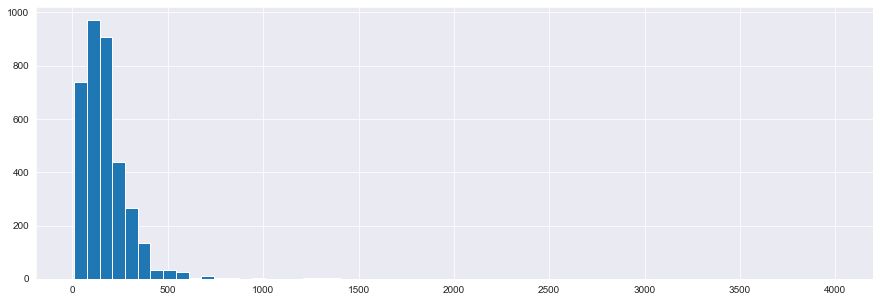

In [174]:
df_boston.price.hist(figsize=(15, 5), bins=60)

In [175]:
df_boston = df_boston[df_boston.price < 700]
df_boston.shape

(3560, 42)

### 2.5 Drop rows with >30% data missing

Text(0.5, 0, '% percentage of missing columns for each row')

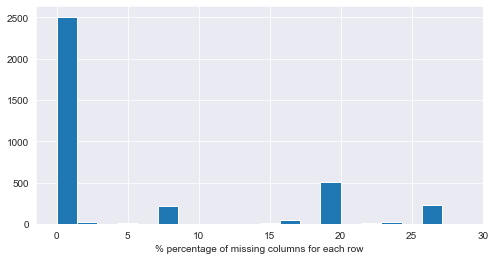

In [176]:
# missing data in each row
missing_row_ct = df_boston.isnull().sum(axis = 1)
missing_row_ct.sort_values(ascending = False, inplace=True)
missing_row_pct = missing_row_ct/(df_boston.shape[1]) * 100

# percentage of missing data in each row
missing_row_pct.hist(figsize=(8, 4), bins=20)
plt.xlabel('% percentage of missing columns for each row')

In [177]:
# delete rows with 30% more value missing, 0 rows deleted
df_boston = df_boston[df_boston.isnull().sum(axis=1) < df_boston.shape[1] * 0.3]
df_boston.shape

(3560, 42)

### 2.6 Impute nulls in columns
The majority of columns have no missing values. For those having missing values, no single column has missing value than 25%. We will impute the nulls with mean or mode values. 

Text(0, 0.5, 'missing %')

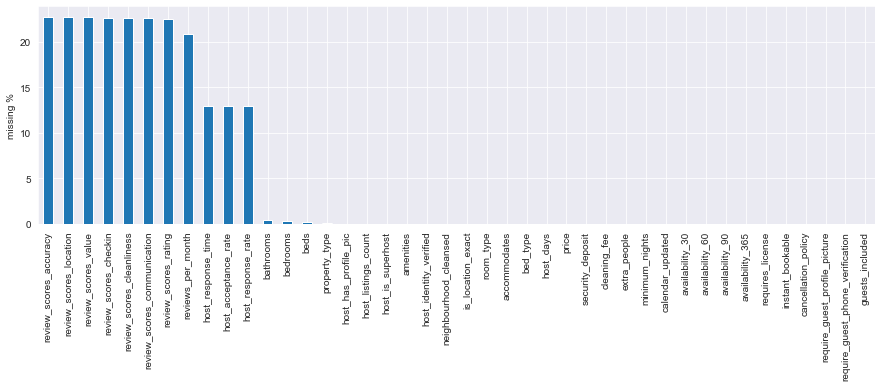

In [178]:
# missing data in each column
missing_ct = df_boston.isnull().sum()
missing_ct.sort_values(ascending = False, inplace=True)
missing_pct = missing_ct/(df_boston.shape[0]) * 100

# percentage of missing data in each column.
missing_pct.plot.bar(figsize=(15, 4))
plt.ylabel('missing %')

In [179]:
# fillna with mode for categorical columns, and the numeric columns that only take integer/fixed values
for col in ['host_response_time','property_type','bathrooms','bedrooms', 'beds']:
    df_boston[col].fillna(df_boston[col].mode().iloc[0], inplace=True)

In [180]:
# fillna with mean for numeric columns
df_boston.fillna(df_boston.mean(), inplace=True)

In [181]:
# double check there is no null values
df_boston.isnull().mean()[df_boston.isnull().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

### 2.7 Convert 'amenities' to individual amenity

In [182]:
df_boston['amenities'].replace(to_replace='[\{\}\"]', value='', regex=True, inplace=True)
amenities_dummy = df_boston['amenities'].str.get_dummies(sep=',').add_prefix('amenity_')

# concatenate all individual amenities column with the full dataset
df_boston = pd.concat([df_boston, amenities_dummy], axis=1, sort=False)
df_boston.drop(columns=['amenities'], inplace=True, axis=1)

In [183]:
# create a list of object columns
cols_cat = df_boston.select_dtypes(include=[object]).columns.to_list()

### 2.8 One-hot encoding of categorical fetures

In [184]:
df_boston = pd.get_dummies(data=df_boston, prefix=cols_cat, prefix_sep='_', columns=cols_cat, drop_first=True)

### 2.9 Final review of the processed data

In [185]:
df_boston.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_days,amenity_24-Hour Check-in,amenity_Air Conditioning,amenity_Breakfast,amenity_Buzzer/Wireless Intercom,amenity_Cable TV,amenity_Carbon Monoxide Detector,amenity_Cat(s),amenity_Dog(s),amenity_Doorman,amenity_Dryer,amenity_Elevator in Building,amenity_Essentials,amenity_Family/Kid Friendly,amenity_Fire Extinguisher,amenity_First Aid Kit,amenity_Free Parking on Premises,amenity_Free Parking on Street,amenity_Gym,amenity_Hair Dryer,amenity_Hangers,amenity_Heating,amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Internet,amenity_Iron,amenity_Kitchen,amenity_Laptop Friendly Workspace,amenity_Lock on Bedroom Door,amenity_Other pet(s),amenity_Paid Parking Off Premises,amenity_Pets Allowed,amenity_Pets live on this property,amenity_Pool,amenity_Safety Card,amenity_Shampoo,amenity_Smoke Detector,amenity_Smoking Allowed,amenity_Suitable for Events,amenity_TV,amenity_Washer,amenity_Washer / Dryer,amenity_Wheelchair Accessible,amenity_Wireless Internet,amenity_translation missing: en.hosting_amenity_49,amenity_translation missing: en.hosting_amenity_50,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,is_location_exact_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,require_guest_profile_picture_t,require_guest_phone_verification_t
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12147973,0.950284,0.841404,1,4,1.5,2.0,3.0,250.0,0,1,1,0,2,14,0,0,0,0,91.888406,9.429818,9.255898,9.645114,9.645372,9.412214,9.166788,1.976816,511,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3075044,1.000000,1.000000,1,2,1.0,1.0,1.0,65.0,1,1,0,0,2,7,26,54,84,359,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.300000,1553,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0
6976,1.000000,0.880000,1,2,1.0,1.0,1.0,65.0,0,0,1,1,3,5,19,46,61,319

In [186]:
df_boston.shape

(3560, 127)

# 3. Seattle Listing Data Cleaning

### 3.1 Load the data

In [188]:
# read Seattle listing data, ignore 'access','interaction','house_rules' columns, set 'id' as index
df_seattle = pd.read_csv('seattle\listings.csv', sep=',', index_col='id', 
                 parse_dates=['last_scraped', 'host_since'], na_filter=True)

In [189]:
df_seattle.head(3)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
3308979,

In [190]:
df_seattle.shape

(3818, 91)

### 3.2 Drop unnecessary columns
feat_info.csv was manually created and contains info about necessary property/actions to each column, such as id, numeric, categorical, location, drop, convert to numeric and convert to date etc.
It is worth mentioning why certain columns were dropped.
1. host_total_listings_count/calculated_host_listings_count: high correlation with host_listings_count
2. host_verifications: use host_identity_verified
3. zipcode: use neighbourhood_cleansed 
4. weekly_price/monthly_price: somewhat related to dependent variable or target daily 'price'. From an AirBnB home landlord's perspective, he/she is mostly like to set the daily 'price' first, before setting weekly_price/monthly_price charge.
5. number_of_reviews: use reviews_per_month

In [191]:
feat_info = pd.read_csv('feat_info.csv', sep=',')

# drop unnecessary columns
column_dropped_1 = feat_info[feat_info.action == 'drop']['name'].to_list()
df_seattle.drop(columns = column_dropped_1, axis=1, inplace = True)
df_seattle.shape

(3818, 43)

### 3.3 Convert data
'extra_people' is somewhat related to dependent variable or target 'price'. From a home landlord's perspective, he/she is mostly like to set the price first, before setting 'extra_people' charge. This means 'extra_people' can be ignored. However, 'extra_people' does affect the 'price' to some extend. To keep this effect, 0/1 dummy was used. The same applies to security_deposit' and 'cleaning_fee'.

In [192]:
# object to numeric
df_seattle['host_acceptance_rate'] = df_seattle['host_acceptance_rate'].str.replace('%', '').astype(float)/100
df_seattle['host_response_rate'] = df_seattle['host_response_rate'].str.replace('%', '').astype(float)/100
df_seattle['price'] = df_seattle['price'].replace('[$,]', '', regex=True).astype(float)
df_seattle['extra_people'] = df_seattle['extra_people'].replace('[$,]', '', regex=True).astype(float)

# convert to 0/1
df_seattle['extra_people'] = df_seattle['extra_people'].apply(lambda x: 1 if x>0 else 0)
# https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
df_seattle[['security_deposit', 'cleaning_fee']] = df_seattle[['security_deposit', 'cleaning_fee']].notnull().astype('int')

# calculate host days
df_seattle['host_days'] = (df_seattle['last_scraped'] - df_seattle['host_since']).dt.days

# convert calendar_updated to numeric days
calendar_updated_dict = {'today': 0, '2 weeks ago': 14, 'a week ago': 7, '3 weeks ago': 21, '2 months ago': 60, 'yesterday': 1, '4 weeks ago': 28, '3 months ago': 90, '4 days ago': 4, '5 weeks ago': 35, '3 days ago': 3, '5 days ago': 5, '4 months ago': 120, '6 weeks ago': 42, '2 days ago': 2, '5 months ago': 150, '7 weeks ago': 49, '7 months ago': 210, '6 days ago': 6, '1 week ago': 7, '6 months ago': 180, '8 months ago': 240, '10 months ago': 300, '9 months ago': 270, 'never': -1, '11 months ago': 330, '13 months ago': 390, '14 months ago': 420, '12 months ago': 360, '17 months ago': 510, '15 months ago': 450, '16 months ago': 480, '22 months ago': 660, '18 months ago': 540, '25 months ago': 750, '30 months ago': 900, '20 months ago': 600, '23 months ago': 690} 
df_seattle.calendar_updated.replace(calendar_updated_dict, inplace=True)
df_seattle['calendar_updated'] = np.where(df_seattle['calendar_updated'] <0, df_seattle['host_days'], df_seattle['calendar_updated']).astype(int)
df_seattle.drop(columns=['last_scraped','host_since'], axis=1, inplace=True)

### 3.4 Drop outliers
From the histogram of our target variable 'price', it is easy to observe that 'price' has a wide range of values. 
The extreme values (outliers) may affect the predicting power of the final model. Thus, some rows with extreme values of 'price' will be deleted. 
From the plot, it seems $600 is a good cutoff point. A total of 18 rows were deleted.

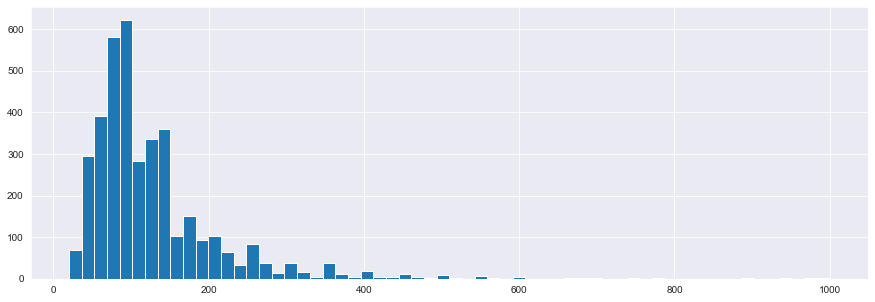

In [193]:
df_seattle.price.hist(figsize=(15, 5), bins=60)

In [194]:
df_seattle = df_seattle[df_seattle.price < 600]
df_seattle.shape

(3800, 42)

### 3.5 Drop rows with >30% data missing

Text(0.5, 0, '% percentage of missing columns for each row')

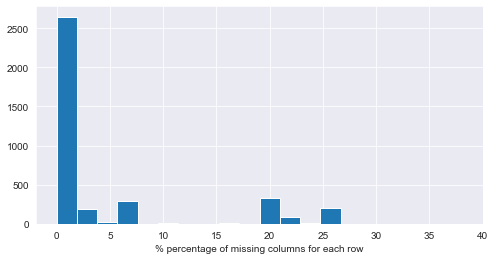

In [195]:
# missing data in each row
missing_row_ct = df_seattle.isnull().sum(axis = 1)
missing_row_ct.sort_values(ascending = False, inplace=True)
missing_row_pct = missing_row_ct/(df_seattle.shape[1]) * 100

# percentage of missing data in each row
missing_row_pct.hist(figsize=(8, 4), bins=20)
plt.xlabel('% percentage of missing columns for each row')

In [196]:
# delete rows with 30% more value missing, 2 rows deleted
df_seattle = df_seattle[df_seattle.isnull().sum(axis=1) < df_seattle.shape[1] * 0.3]
df_seattle.shape

(3798, 42)

### 3.6 Impute nulls in columns
The majority of columns have no missing values. For those having missing values, no single column has missing value than 25%. We will impute the nulls with mean or mode values. 

Text(0, 0.5, 'missing %')

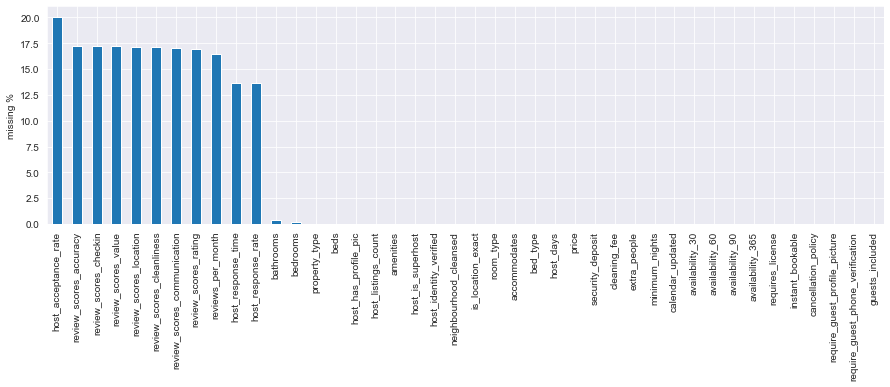

In [197]:
# missing data in each column
missing_ct = df_seattle.isnull().sum()
missing_ct.sort_values(ascending = False, inplace=True)
missing_pct = missing_ct/(df_seattle.shape[0]) * 100

# percentage of missing data in each column.
missing_pct.plot.bar(figsize=(15, 4))
plt.ylabel('missing %')

In [198]:
# fillna with mode for categorical columns, and the numeric columns that only take integer/fixed values
for col in ['host_response_time','property_type','bathrooms','bedrooms', 'beds']:
    df_seattle[col].fillna(df_seattle[col].mode().iloc[0], inplace=True)

In [199]:
# fillna with mean for numeric columns
df_seattle.fillna(df_seattle.mean(), inplace=True)

In [200]:
# double check there is no null values
df_seattle.isnull().mean()[df_seattle.isnull().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

### 3.7 Convert 'amenities' to individual amenity

In [201]:
df_seattle['amenities'].replace(to_replace='[\{\}\"]', value='', regex=True, inplace=True)
amenities_dummy = df_seattle['amenities'].str.get_dummies(sep=',').add_prefix('amenity_')

# concatenate all individual amenities column with the full dataset
df_seattle = pd.concat([df_seattle, amenities_dummy], axis=1, sort=False)
df_seattle.drop(columns=['amenities'], inplace=True, axis=1)

In [202]:
# create a list of object columns
cols_cat = df_seattle.select_dtypes(include=[object]).columns.to_list()

### 3.8 One-hot encoding of categorical fetures

In [203]:
df_seattle = pd.get_dummies(data=df_seattle, prefix=cols_cat, prefix_sep='_', columns=cols_cat, drop_first=True)

### 3.9 Final review of the processed data

In [204]:
df_seattle.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_days,amenity_24-Hour Check-in,amenity_Air Conditioning,amenity_Breakfast,amenity_Buzzer/Wireless Intercom,amenity_Cable TV,amenity_Carbon Monoxide Detector,amenity_Cat(s),amenity_Dog(s),amenity_Doorman,amenity_Dryer,amenity_Elevator in Building,amenity_Essentials,amenity_Family/Kid Friendly,amenity_Fire Extinguisher,amenity_First Aid Kit,amenity_Free Parking on Premises,amenity_Gym,amenity_Hair Dryer,amenity_Hangers,amenity_Heating,amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Internet,amenity_Iron,amenity_Kitchen,amenity_Laptop Friendly Workspace,amenity_Lock on Bedroom Door,amenity_Other pet(s),amenity_Pets Allowed,amenity_Pets live on this property,amenity_Pool,amenity_Safety Card,amenity_Shampoo,amenity_Smoke Detector,amenity_Smoking Allowed,amenity_Suitable for Events,amenity_TV,amenity_Washer,amenity_Washer / Dryer,amenity_Wheelchair Accessible,amenity_Wireless Internet,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleans

In [205]:
df_seattle.shape

(3798, 187)

# 4. Compare superhost vs regular_host

### 4. 1 Load the data

In [207]:
# df_boston = pd.read_csv('results\df_listings_boston.csv', sep=',', index_col='id')
# df_seattle = pd.read_csv('results\df_listings_seattle.csv', sep=',', index_col='id')
print("Boston listing data shape:  {}".format(df_boston.shape))
print("Seattle listing data shape: {}".format(df_seattle.shape))

Boston listing data shape:  (3560, 127)
Seattle listing data shape: (3798, 187)


In [208]:
# Counts of regular_host vs superhost in Boston
df_boston.groupby('host_is_superhost_t').size().reset_index(name='counts')

,host_is_superhost_t,counts
0,0,3157
1,1,403


In [209]:
# Counts of regular host vs super_host in Seattle
df_seattle.groupby('host_is_superhost_t').size().reset_index(name='counts')

,host_is_superhost_t,counts
0,0,3024
1,1,774


### 4.2 Compare superhost vs regular_host in Boston
Boston has 403 superhosts and 3157 regular hosts, while Seattle has 774 superhosts and 3024 regular hosts. Seattle has a higher proportion of superhosts than Boston.
We will compare the mean of each data column between superhosts and regular hosts, and find out those that have a percentage difference higher than 30%, ignoring all neighbourhood columns.

In [210]:
# Boston regular_host vs Super_host
df_Boston_groupby_host = df_boston.groupby(['host_is_superhost_t']).mean().T.reset_index()
df_Boston_groupby_host.rename(columns={'index':'column', 0:'regular_host', 1:'superhost'}, inplace=True)

df_Boston_groupby_host['host_diff_%'] = (df_Boston_groupby_host.superhost - df_Boston_groupby_host.regular_host)\
                                        /df_Boston_groupby_host.regular_host*100

df_Boston_groupby_host[(df_Boston_groupby_host['host_diff_%']>30) & 
                       (~df_Boston_groupby_host.column.str.startswith('neighbourhood'))]\
                        .sort_values(by='superhost', ascending=False)

host_is_superhost_t,column,regular_host,superhost,host_diff_%
25,reviews_per_month,1.861839,2.877515,54.552314
61,amenity_Shampoo,0.652835,0.868486,33.033062
45,amenity_Hair Dryer,0.485588,0.665012,36.950044
40,amenity_Fire Extinguisher,0.419385,0.607940,44.959818
11,extra_people,0.363320,0.555831,52.986862
27,amenity_24-Hour Check-in,0.330060,0.491315,48.856227
41,amenity_First Aid Kit,0.272411,0.491315,80.358359
8,security_deposit,0.361419,0.473945,31.134589
121,cancellation_policy_moderate,0.248337,0.334988,34.892325
42,amenity_Free Parking on Premises,0.219512,0.330025,50.344637


### Discussion
In Boston, compared to regular hosts, superhosts tend to:
1. have more reviews_per_month.
2. charge extra_people. 
3. offer better services, such as more chances of having Shampoo, Hair Dryer, Fire_Extinguisher, First Aid Kit, 24-Hour Check-in, cancellation_policy_moderate, Safety Card, Breakfast, Free Parking on Premises, Indoor Fireplace
4. be more pet friendly. They tend to have Dogs, Cat(s), Other Pet(s), Pets live on this property.
5. require security_deposit, and guest_profile_picture.
6. have more chances to offer Houses.

### 4.3 Compare superhost vs regular_host in Seattle

In [211]:
df_seattle_groupby_host = df_seattle.groupby(['host_is_superhost_t']).mean().T.reset_index()
df_seattle_groupby_host.rename(columns={'index':'column', 0:'regular_host', 1:'superhost'}, inplace=True)

df_seattle_groupby_host['host_diff_%'] = (df_seattle_groupby_host.superhost - df_seattle_groupby_host.regular_host)\
                                        /df_seattle_groupby_host.regular_host*100

df_seattle_groupby_host[(df_seattle_groupby_host['host_diff_%']>30) & 
                        (~df_seattle_groupby_host.column.str.startswith('neighbourhood'))]\
                        .sort_values(by='superhost', ascending=False)

host_is_superhost_t,column,regular_host,superhost,host_diff_%
25,reviews_per_month,1.865071,2.945044,57.905165
11,extra_people,0.435847,0.569767,30.726612
41,amenity_First Aid Kit,0.409722,0.556848,35.908553
56,amenity_Pets live on this property,0.210979,0.310078,46.970912
58,amenity_Safety Card,0.169643,0.270026,59.173127
44,amenity_Hair Dryer,0.189153,0.254522,34.558465
181,instant_bookable_t,0.139550,0.214470,53.686763
27,amenity_24-Hour Check-in,0.151124,0.200258,32.512340
34,amenity_Dog(s),0.119048,0.186047,56.279070
185,require_guest_phone_verification_t,0.082672,0.157623,90.660465


### Discussion
In Seattle, compared to regular hosts, superhosts tend to:
1. have more reviews_per_month.
2. charge extra_people. 
3. offer better services, such as more chances of having Doorman, Safety Card, First Aid Kit, Hair Dryer, instant_bookable, 24-Hour Check-in etc.. 
4. be more pet friendly. They tend to have Dogs, Cat(s), Pets live on this property, 
5. require guest_profile_picture and guest_phone_verification.
6. have more chances to offer exotic property types, such as Yurt, Cabin, Treehouse, Camper/RV, Loft etc.. Keep in mind though, the overall number of superhosts offering these kinds of property types are slim though. 

# 5. AirBnB price modeling - Boston and Seattle

### 5.1 Load the processed data

In [213]:
# df_boston = pd.read_csv('results\df_listings_boston.csv', sep=',', index_col='id')
# df_seattle = pd.read_csv('results\df_listings_seattle.csv', sep=',', index_col='id')
print("Boston listing data shape:  {}".format(df_boston.shape))
print("Seattle listing data shape: {}".format(df_seattle.shape))

Boston listing data shape:  (3560, 127)
Seattle listing data shape: (3798, 187)


### 5.2 Define Lasso model
1. StandardScaler was used to transform the data X. Scaler was performed on X_train and X_test separately. 
2. LassoCV was used to perform feature selection and to find best model (alpha) automatically.

In [214]:
def lasso_model(df):
    y = df['price']
    X= df.drop(columns=['price'], axis=1)

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # scale the data
    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # use LassoCV to find best alpha automatically
    lasso_model = LassoCV(cv=4, random_state=0) # Instantiate
    lasso_model.fit(X_train, y_train) #Fit

    train_score=lasso_model.score(X_train,y_train)
    test_score=lasso_model.score(X_test,y_test)
    coeff_used = np.sum(lasso_model.coef_!=0)

    print("best alpha: {}".format(lasso_model.alpha_))
    print("training score: {}".format(train_score))
    print("test score: {}".format(test_score))
    print("number of features used: {}".format(coeff_used))

    # find model's correlation coefficients
    coef = pd.Series(lasso_model.coef_, index = X.columns)
    coef.sort_values(ascending=False, inplace=True)
    print('\n')
    print(coef)
    
    # plot model's correlation coefficients
    imp_coef = pd.concat([coef.sort_values().head(16), coef.sort_values().tail(20)])
    plt.figure(figsize=(10, 15))
    imp_coef.plot(kind = 'barh')
    plt.title('Coefficients in the Lasso Model')

### 5.3 Boston price model
For Boston listing, the scores of both training and test data sets are 0.66, which are reasonably good. The final number of features used is 89. The list of coefficients shows the magnitude of each feature importance. 
For Boston listing, neighbourhood matters. And the price can go either up or down depending on the neighbourhood.

#### Positively correlated factors with correlation coefficient > 3
1. bedrooms, bathrooms, beds, accomodates, guest_included
 * This makes perfect sense. The more these variables are, the higher the price is. 
2. require_guest_phone_verification, host_is_superhost, calendar_updated, cancellation_policy_super_strict_30
 * These variables are somewhat related to the hosts' rental policies/characteristics. 
 * If require_guest_phone_verification is True, it is possibly because the host values his/her property. The more the host values his/her property, the more tendency the host will set the price high. 
 * The same logic above explains why cancellation_policy_super_strict_30 is positively correlated with price. 
 * Superhost's price tends to be higher than regular hosts. This is possibly because superhosts offer more values based on  services/aminities. 
 * The positive correlation between calendar_updated and price is somewhat hard to explain. One possible explanation is the longer the host has not updated his/her AirBnB calendar, the more hesitant the host is willing to rent his property, thus the higher rental price. 

3. amenity - TV, Air Conditioning, Indoor Fireplace, Doorman 
 * This makes perfect sense. Having Air Conditioning in summer, and Indoor Fireplace is desirable in Boston.
 * The presense of Doorman can also increase perceived value (thus charge higher price) by giving a sense of security to the potential customers.


#### Negatively correlated factors with correlation coefficient absolute value > 3
1. room_type Shared room, Private room
 * This makes sense. The whole house/apartment is always a better option if you can afford it. 
2. extra_people 
 * If there is a charge for extra people, the price is relatively lower. Sounds reasonable.
3. reviews_per_month, host_listings_count, require_guest_profile_picture
 * The more reviews_per_month, the lower the price tends to be. In the old days, consumers trust word of mouth. Nowdays, consumers read reviews. The more (positive) reviews, the better. To some extent, having no review is as bad as having slightly negative reviews, because it is hard for guests to trust your property. So hosts strive for reviews, especially positive reviews. To solicit more reviews, hosts have to attract more guests. One way is by charging slightly lower price. 
 * The more host_listings_counts, the lower the price is. One possible explanation is as the host owns more listings, the economy of scale will lower the average fixed cost per property, which enables the host to gain equal or higher profit while charging a lower price.
 * require_guest_profile_picture is negatively correlated with price. The host tends to trust guests with profile pictures. The host does not mind charging a slightly lower price knowing the guest(s) will take good care of his/her property. 
4. amenity - Free Parking on Premises, Kitchen, Hangers
 * It is possible that free parking is mostly offered at areas further away from blockbuster locations. As a result, the rental price tends to be cheaper. 
 * The same logic applies to Kitchen. 
 * For Hangers?
5. minimum_nights
 * The longer the rental period, the cheaper the price. Sounds reasonable. 

best alpha: 0.7345744435570088
training score: 0.6599006914891123
test score: 0.6638489338079512
number of features used: 89


bedrooms                              24.042260
neighbourhood_cleansed_Back Bay       16.983291
neighbourhood_cleansed_Beacon Hill    12.602399
neighbourhood_cleansed_South End      11.447879
accommodates                          11.326117
                                        ...    
reviews_per_month                     -6.340251
extra_people                          -6.723574
neighbourhood_cleansed_Dorchester     -7.178877
room_type_Shared room                 -9.221237
room_type_Private room               -26.435829
Length: 126, dtype: float64


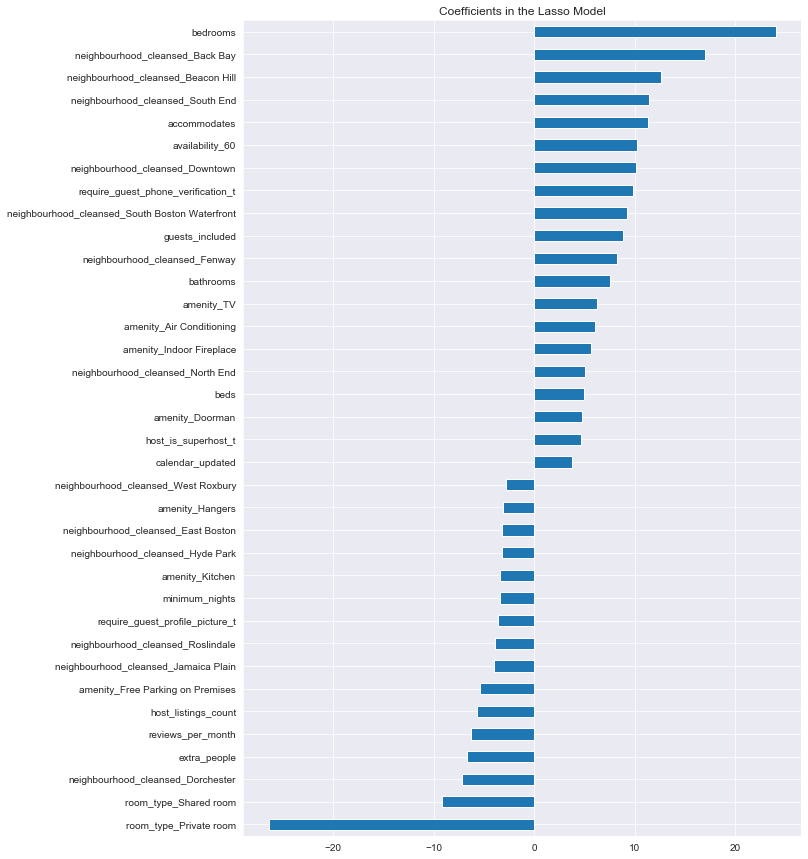

In [215]:
lasso_model(df_boston)

### 5.4 Seattle price model
For Seattle listing, the training score is 0.68, while the test score is 0.63, which are reasonably good. The final number of features used is 149. The list of coefficients shows the magnitude of each feature importance. 
Just like Boston listing, neighbourhood matters in Seattle too. And the price can go either up or down depending on the neighbourhood.

#### Positively correlated factors with correlation coefficient > 3
1. bedrooms, accomodates, bathrooms, guest_included, beds
 * This makes perfect sense. The more these variables are, the higher the price is. 
2. review_scores_rating, host_is_superhost, calendar_updated
 * These variables are somewhat related to the hosts' rental policies/characteristics.
 * review_scores_rating - the higher review score rating, the better services/values provided to the guests, the more guests interested, the higher demand, the higher price.
 * Superhost - same as the explanation for Boston
 * calendar_updated - same as the explanation for Boston
3. Amenity - Doorman, Elevator in Building
 * Doorman - same as the explanation for Boston
 * Elevator in Building - valuable to some guests. More value, higher price. 

#### Negatively correlated factors  with correlation coefficient absolute value > 2
1. room_type Private room， Shared room, Dorm
 * This makes sense. The whole house/apartment is always a better option if you can afford it. 
2. host_acceptance_rate， extra_people, reviews_per_month, review_scores_value
 * host_acceptance_rate - more possibly because of correlation only, not causal relationship. For some properties that are hard to get booked, such as remote areas, the hosts have no choice but to accept any reservation while charging a low price.
 * extra_people - same as the explanation for Boston
 * reviews_per_month - same as the explanation for Boston
 * review_scores_value: Value shopping guests tend to maximize utility/price. By doing so, they tend to choose properties that ask for lower prices. 


best alpha: 0.3009697813983334
training score: 0.6809131398220695
test score: 0.6345227147681203
number of features used: 149


bedrooms                                 24.812787
accommodates                             12.848408
bathrooms                                 9.754120
neighbourhood_cleansed_Broadway           6.573381
neighbourhood_cleansed_Pioneer Square     5.873957
                                           ...    
reviews_per_month                        -4.409133
extra_people                             -5.546166
host_acceptance_rate                     -9.000192
room_type_Shared room                   -12.926596
room_type_Private room                  -16.952159
Length: 186, dtype: float64


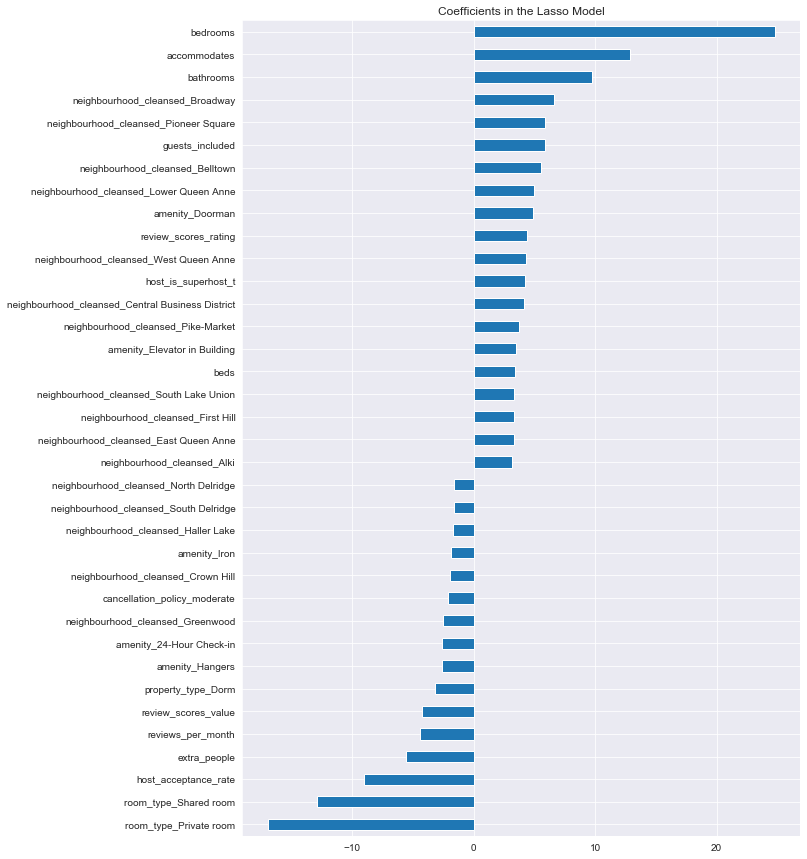

In [216]:
lasso_model(df_seattle)